## Sentiment Classification of Tweets
### Using Logistic Regression, Random Forest, Support Vector Machine, and Latent Dirichlet Allocation
#### Kevin Wang

In [1]:
import pandas as pd
import numpy as np
import re, spacy, os, warnings, pyLDAvis, pyLDAvis.lda_model
import matplotlib.pyplot as plt
import seaborn as sns
import scattertext as st
from spacy import displacy
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.base import BaseEstimator
from sklearn.decomposition import LatentDirichletAllocation

## 1. Load csvs and concatenate the following three columns into a new column of tweet_texts: Location, TweetAt, OriginalTweet

In [2]:
train = pd.read_csv(r"C:\Users\Wangs\OneDrive\Documents\Maryville Courses\DSCI 614\Projects\Final\Corona_NLP_train.csv",encoding='latin-1')
test = pd.read_csv(r"C:\Users\Wangs\OneDrive\Documents\Maryville Courses\DSCI 614\Projects\Final\Corona_NLP_test.csv", encoding='latin-1')

In [3]:
cols = ['Location', 'TweetAt', 'OriginalTweet']
# Concat columns separated by a whitespace
train['tweet_texts'] = train[cols].apply(lambda row: ' '.join(row.values.astype('str')), axis=1)
train.drop(cols, axis=1, inplace=True)
test['tweet_texts'] = test[cols].apply(lambda row: ' '.join(row.values.astype('str')), axis=1)
test.drop(cols, axis=1, inplace=True)
test.head()

,UserName,ScreenName,Sentiment,tweet_texts
0,1,44953,Extremely Negative,NYC 02-03-2020 TRENDING: New Yorkers encounter...
1,2,44954,Positive,"Seattle, WA 02-03-2020 When I couldn't find ha..."
2,3,44955,Extremely Positive,nan 02-03-2020 Find out how you can protect yo...
3,4,44956,Negative,Chicagoland 02-03-2020 #Panic buying hits #New...
4,5,44957,Neutral,"Melbourne, Victoria 03-03-2020 #toiletpaper #d..."


## 2. Clean and preprocess the new column of tweet_texts.

In [4]:
# Remove the date and time in the tweets using a regular expression
for i, row in enumerate(train['tweet_texts']):
    # Remove dates in the format 03-10-2024 and times in the format 05:30 or 5:30 am or 12 pm
    train.iloc[i,3] = re.sub(r"(\d{2}-\d{2}-\d{4})|(\d{1,2}:\d{2}|\s(am|pm))|(\d{1,2}\s(am|pm))", '', row)
for i, row in enumerate(test['tweet_texts']):
    test.iloc[i,3] = re.sub(r"(\d{2}-\d{2}-\d{4})|(\d{1,2}:\d{2}|\s(am|pm))|(\d{1,2}\s(am|pm))", '', row)

# Remove the hyperlink URL in the tweets using a regular expression.
for i, row in enumerate(train['tweet_texts']):
    # Removes urls
    train.iloc[i,3] = re.sub(r"http\S+", "", row)
for i, row in enumerate(test['tweet_texts']):
    test.iloc[i,3] = re.sub(r"http\S+", "", row)

# Remove the Twitter hashtags(# before a relevant keyword or phrase ) in the tweets using a regular expression
for i, row in enumerate(train['tweet_texts']):
    # Removes all #'s, redundant because we remove all characters later
    train.iloc[i,3] = re.sub("#", "", row)
for i, row in enumerate(test['tweet_texts']):
    test.iloc[i,3] = re.sub("#", "", row)


In [5]:
# Remove the usernames (also known as the handle –– begins with the “@” symbol) using a regular expression
for i, row in enumerate(train['tweet_texts']):
    # Removes all usernames starting with @ followed by alphanumeric or _
    train.iloc[i,3] = re.sub(r"(@[A-Za-z0-9_]+)", '', row)
for i, row in enumerate(test['tweet_texts']):
    test.iloc[i,3] = re.sub(r"(@[A-Za-z0-9_]+)", '', row)

# Remove all special characters, punctuation using a regular expression
for i, row in enumerate(train['tweet_texts']):
    # Removes all not letters, digits, or whitespaces
    train.iloc[i,3] = re.sub(r"[^a-zA-Z0-9\s]", '', row)
for i, row in enumerate(test['tweet_texts']):
    test.iloc[i,3] = re.sub(r"[^a-zA-Z0-9\s]", '', row)

# Remove all words containing at most two characters such as "a", "an", "in", "on", etc
for i, row in enumerate(train['tweet_texts']):
    # Removes any word containing 1 or 2 letters
    train.iloc[i,3] = re.sub(r'\b[a-zA-Z]{1,2}\b', '', row)
for i, row in enumerate(test['tweet_texts']):
    test.iloc[i,3] = re.sub(r'\b[a-zA-Z]{1,2}\b', '', row)

# Replaces multiple spaces with single space
for i, row in enumerate(train['tweet_texts']):
    train.iloc[i,3] = re.sub(' +', ' ', row)
for i, row in enumerate(test['tweet_texts']):
    test.iloc[i,3] = re.sub(' +', ' ', row)

In [6]:
# Remove all rows without any text left (empty text) in the column of tweet_texts
# Replace one space strings with np.nan so dropna() works, ' ' because my last regex expression was to replace multiple spaces with 1 space
# From checking the length of train and test, looks like only 1 row in train was dropped
train['tweet_texts'] = train['tweet_texts'].replace(' ', np.nan)
test['tweet_texts'] = test['tweet_texts'].replace(' ', np.nan)

train.dropna(subset=['tweet_texts'], inplace=True)
test.dropna(subset=['tweet_texts'], inplace=True)

In [7]:
# Perform the part of speech tagging for the texts
nlp = spacy.load("en_core_web_lg")
# Using nlp.pipe to process the entire column at once
doc_train = [doc for doc in nlp.pipe(train["tweet_texts"])]
doc_test = [doc for doc in nlp.pipe(test["tweet_texts"])]

In [8]:
# Only show the POS tagging for first string in both doc_train and doc_test
for token in doc_train[0]:
        print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        token.shape_, token.is_alpha, token.is_stop)
for token in doc_test[0]:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
    token.shape_, token.is_alpha, token.is_stop)

London London PROPN NNP ROOT Xxxxx True False
and and CCONJ CC cc xxx True True
and and CCONJ CC conj xxx True True
NYC NYC PROPN NNP npadvmod XXX True False
TRENDING TRENDING PROPN NNP compound XXXX True False
New New PROPN NNP compound Xxx True False
Yorkers Yorkers PROPN NNPS nsubj Xxxxx True False
encounter encounter VERB VBP ROOT xxxx True False
empty empty ADJ JJ amod xxxx True True
supermarket supermarket NOUN NN compound xxxx True False
shelves shelf NOUN NNS dobj xxxx True False
pictured picture VERB VBD acl xxxx True False
Wegmans Wegmans PROPN NNP compound Xxxxx True False
Brooklyn Brooklyn PROPN NNP compound Xxxxx True False
soldout soldout NOUN NN nmod xxxx True False
online online ADJ JJ amod xxxx True False
grocers grocer NOUN NNS dobj xxxx True False
FoodKick FoodKick PROPN NNP compound XxxxXxxx True False
MaxDelivery MaxDelivery PROPN NNP npadvmod XxxXxxxx True False
coronavirusfearing coronavirusfeare VERB VBG acl xxxx True False
shoppers shopper NOUN NNS dobj xxxx Tr

In [9]:
# Visualize the dependency parser, only showing doc_test[0] because running on entire doc_test lags my notebook after output
displacy.render(doc_test[0], style="dep", jupyter = True)

C:\Users\Wangs\anaconda3\lib\site-packages\spacy\displacy\__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [10]:
# Perform the named entities recognition for the texts, only on first 10 strings of doc_train
for i in range(0,10):
    for ent in doc_train[i].ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)

London 0 6 GPE
Vagabonds Coronavirus Australia Woolworths 0 42 ORG
hoursid 84 91 NORP
nan food stock 0 14 ORG
Confinementotal 217 232 NORP
nan 0 3 PERSON
3631970882363649 1 17 CARDINAL
first 35 40 ORDINAL
Sullivan County 73 88 GPE
last week 89 98 DATE
3592654178753267 0 16 CARDINAL
Cashier 17 24 ORG
Austria 0 7 GPE
today 28 33 DATE
Rebel

toiletpapercrisis 57 85 PRODUCT
Atlanta USA 0 11 ORG
Atlanta 55 62 GPE
the next two weeks 109 127 DATE
Monday March 16 138 153 DATE
19 237 239 CARDINAL
govindia 240 248 ORG
IndiaFightsCorona 249 266 ORG


In [2]:
# Note: Output of this cell discarded due to length in html rendering

# Visualize the GEOLOCATION, MONEY, and QUANTITY in the doc_train
options = {"ents": ['GEOLOCATION','MONEY', 'QUANTITY'], "colors": {'GEOLOCATION':'#82E0AA','MONEY':'#82E0AA', 'QUANTITY':'#82E0AA'}}
displacy.render(doc_train, style="ent", jupyter = True, options=options)

In [12]:
# Extract all the tokens from the tweet_texts
tokens_train = [token.text for token in doc_train[:]]
print(f'There are {len(tokens_train)} tokens in doc_train.')  

tokens_test = [token.text for token in doc_test[:]]
print(f'There are {len(tokens_test)} tokens in doc_test.')        

There are 41156 tokens in doc_train.
There are 3798 tokens in doc_test.


In [13]:
# Replace the Tweet_texts column with the string only containing the lemmas of all the tokens
for i in range(len(doc_train)):
    lemma = ""
    for token in doc_train[i]:
        lemma += token.lemma_ + ' '
        # Removes trailing whitespace from above concatatenation
        lemma.rstrip()
    train.iloc[i,3] = lemma

for i in range(len(doc_test)):
    lemma = ""
    for token in doc_test[i]:
        lemma += token.lemma_ + ' '
        # Removes trailing whitespace from above concatatenation
        lemma.rstrip()
    test.iloc[i,3] = lemma

<Axes: xlabel='Sentiment'>

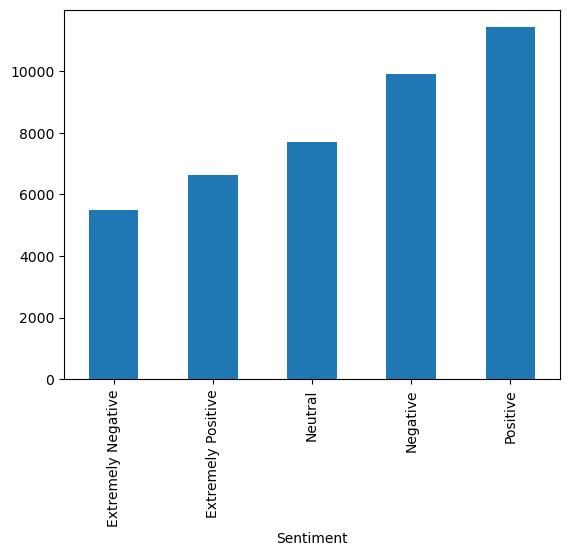

In [14]:
# Graphically summarize the Sentiment
train.Sentiment.value_counts().sort_values().plot(kind = 'bar')

<Axes: xlabel='Sentiment'>

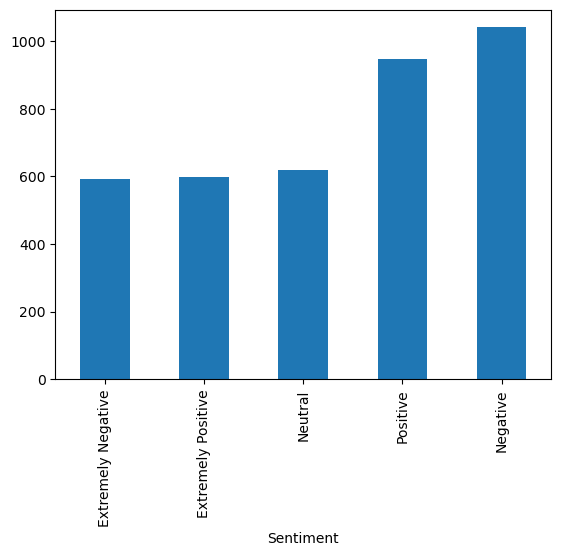

In [15]:
# Graph for test
test.Sentiment.value_counts().sort_values().plot(kind = 'bar')

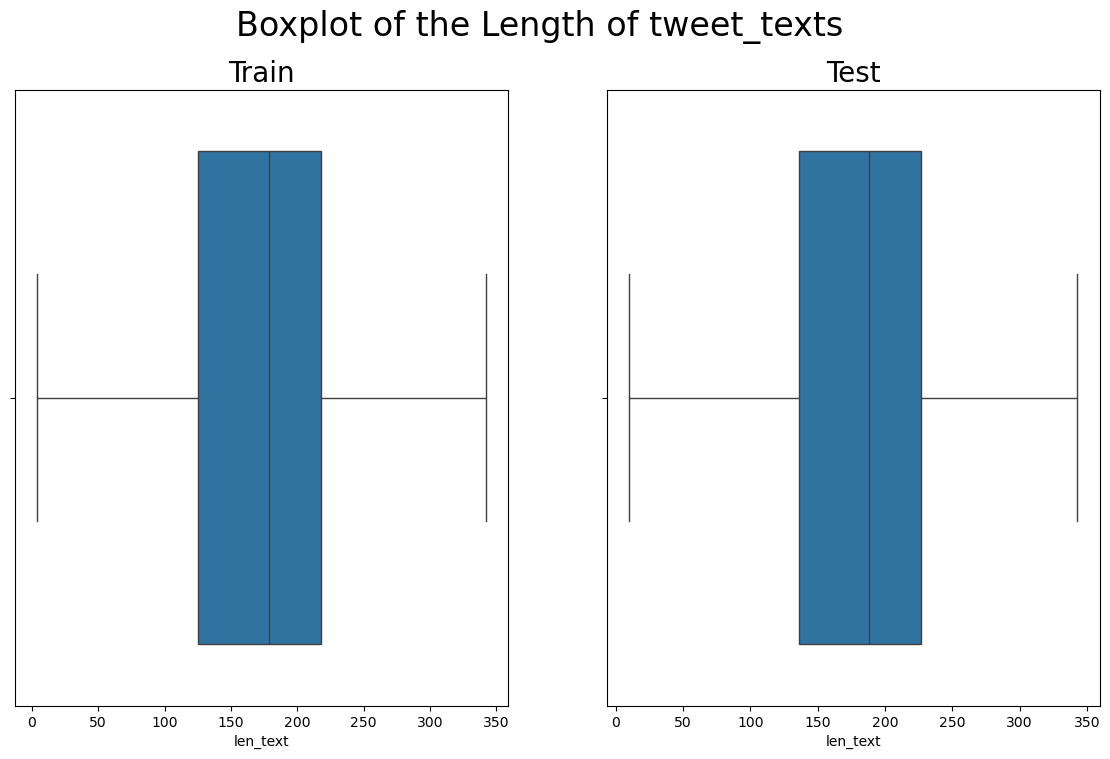

In [16]:
# Graphically summarize the length of the text of the Tweet_texts using boxplot, histogram, and density plot
train["len_text"] = train["tweet_texts"].str.len()
test["len_text"] = test["tweet_texts"].str.len()

fig, axes = plt.subplots(1, 2, figsize = (14, 8))
fig.suptitle('Boxplot of the Length of tweet_texts', fontsize= 24)

sns.boxplot(ax=axes[0], x=train["len_text"])
axes[0].set_title("Train", fontsize= 20)
sns.boxplot(ax=axes[1], x=test["len_text"])
x= axes[1].set_title("Test", fontsize= 20)

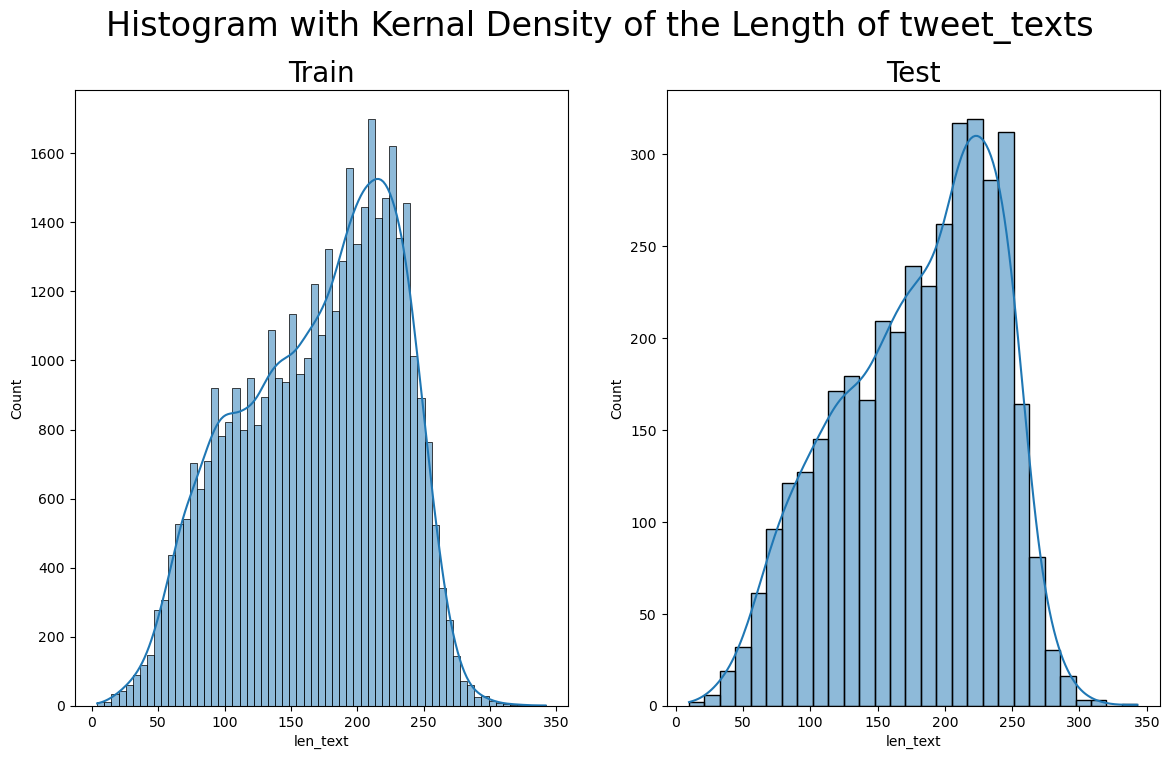

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (14, 8))
fig.suptitle('Histogram with Kernal Density of the Length of tweet_texts', fontsize= 24)

sns.histplot(ax=axes[0], x=train["len_text"], kde = True)
axes[0].set_title("Train", fontsize= 20)
sns.histplot(ax=axes[1], x=test["len_text"], kde = True)
x= axes[1].set_title("Test", fontsize= 20)

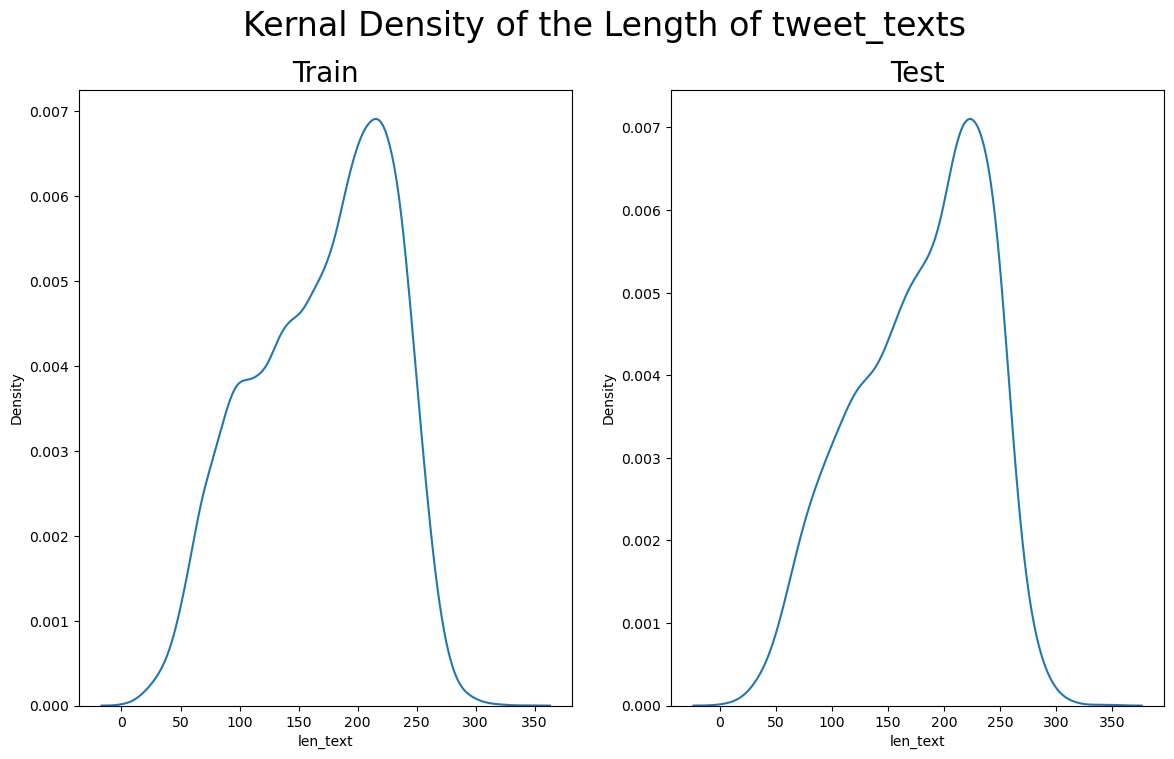

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (14, 8))
fig.suptitle('Kernal Density of the Length of tweet_texts', fontsize= 24)

sns.kdeplot(ax=axes[0], x=train["len_text"])
axes[0].set_title("Train", fontsize= 20)
sns.kdeplot(ax=axes[1], x=test["len_text"])
x= axes[1].set_title("Test", fontsize= 20)

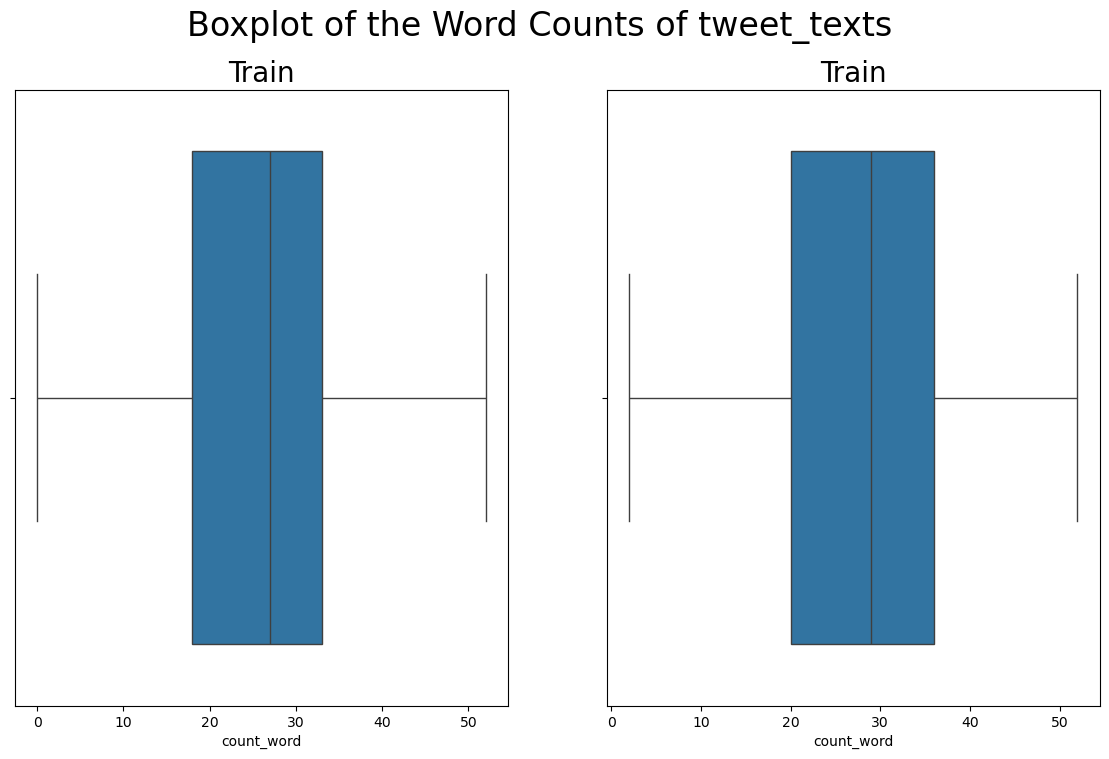

In [19]:
# Graphically summarize the word count of the text of the Tweet_texts using boxplot, histogram, and density plot
train["count_word"] = train["tweet_texts"].str.split().str.len()
test["count_word"] = test["tweet_texts"].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize = (14, 8))
fig.suptitle('Boxplot of the Word Counts of tweet_texts', fontsize= 24)

# Plot the original texts
sns.boxplot(ax=axes[0], x=train["count_word"])
axes[0].set_title("Train", fontsize= 20)
# Plot the cleaned texts
sns.boxplot(ax=axes[1], x=test["count_word"])
x= axes[1].set_title("Train", fontsize= 20)

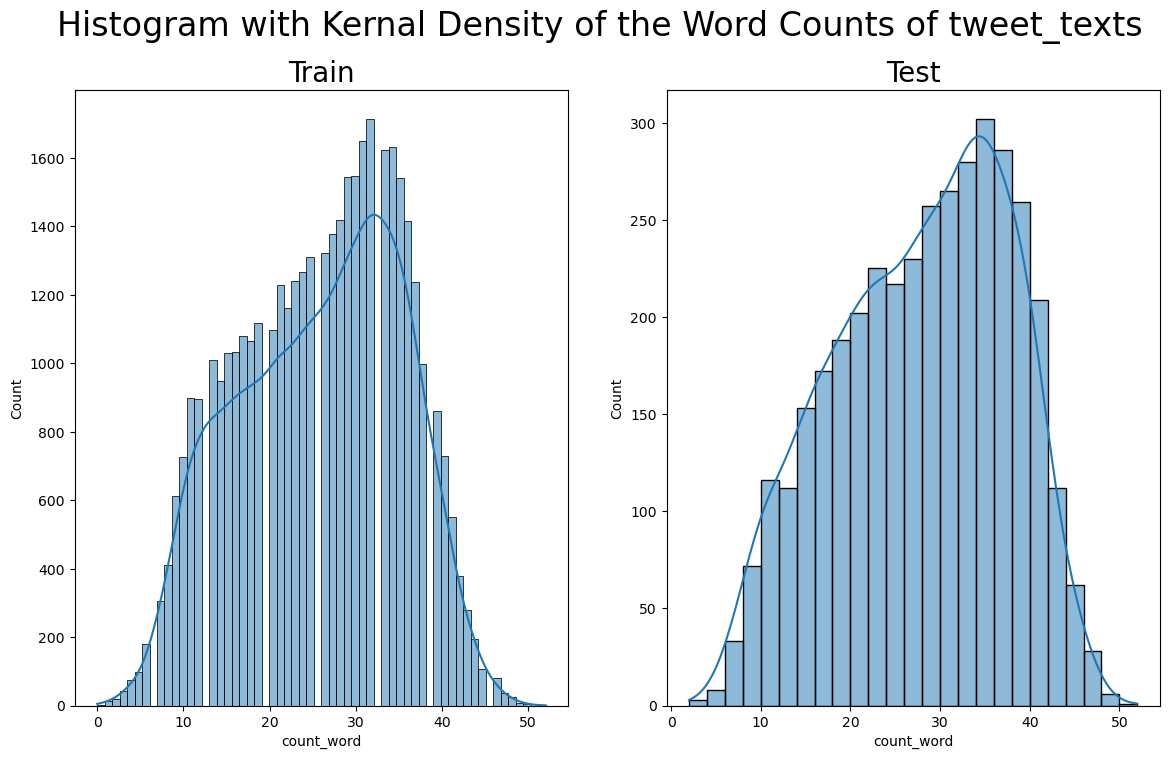

In [20]:
fig, axes = plt.subplots(1, 2, figsize = (14, 8))
fig.suptitle('Histogram with Kernal Density of the Word Counts of tweet_texts', fontsize= 24)

sns.histplot(ax=axes[0], x=train["count_word"], kde=True)
axes[0].set_title("Train", fontsize= 20)
sns.histplot(ax=axes[1], x=test["count_word"], kde=True)
x= axes[1].set_title("Test", fontsize= 20)

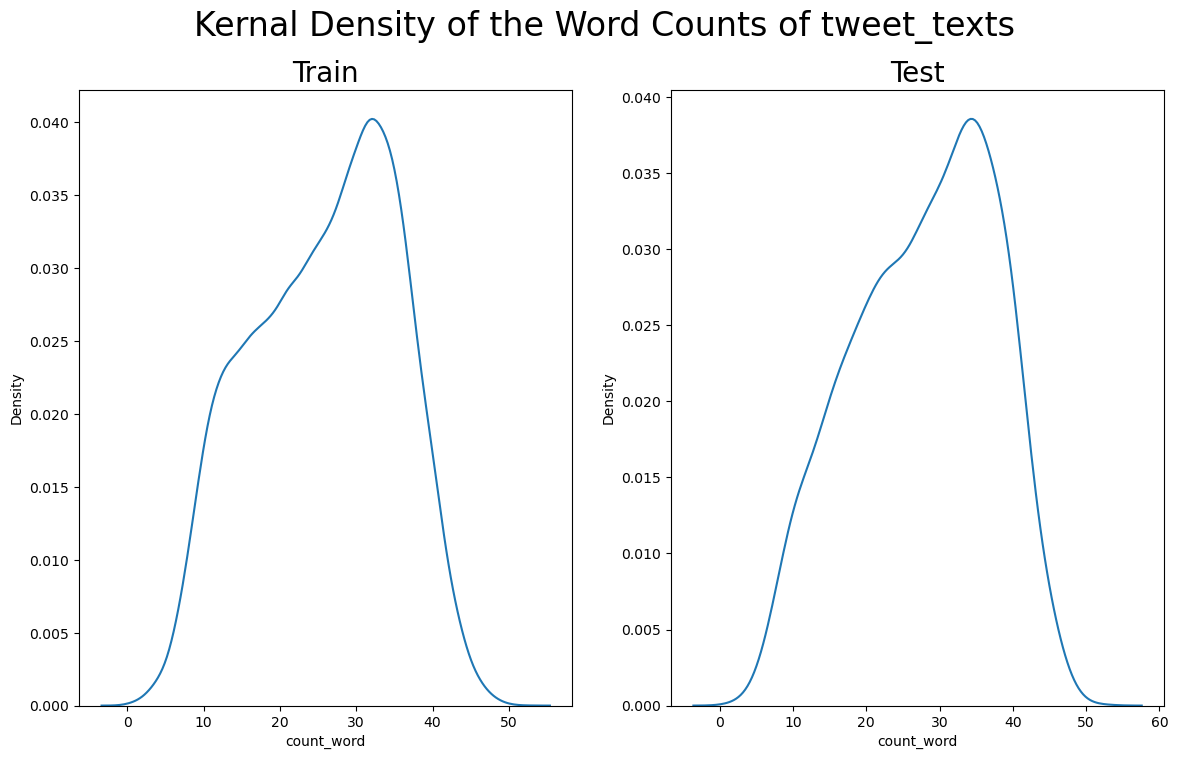

In [21]:
fig, axes = plt.subplots(1, 2, figsize = (14, 8))
fig.suptitle('Kernal Density of the Word Counts of tweet_texts', fontsize= 24)

sns.kdeplot(ax=axes[0], x=train["count_word"])
axes[0].set_title("Train", fontsize= 20)
sns.kdeplot(ax=axes[1], x=test["count_word"])
x= axes[1].set_title("Test", fontsize= 20)

In [22]:
# Graphically summarize the top 10 unigram and bigrams of the tf-idf of the text of the tweet_texts
# ngram_range set for unigrams and bigrams
def get_top_tf_idf_words(df, col = "tweet_texts", use_idf = True, ngram_range =(1, 2), top_n=10):
    tf_idf = TfidfVectorizer(ngram_range = ngram_range, use_idf = use_idf, stop_words='english')
    # Fit and transform the corpus
    X_sparse_matrix = tf_idf.fit_transform(df[col].apply(lambda x: np.str_(x)))
    feature_names = np.array(tf_idf.get_feature_names_out())
    # Generate the tf-idf matrix
    tf_idf_sparse_matrix = tf_idf.transform(df[col].apply(lambda x: np.str_(x)))
    # Rank the matrix by tf-idf values and return the indices of the top_n values
    sorted_idx = np.argsort(tf_idf_sparse_matrix.data)[:-(top_n+1):-1]

    # Return the feature names and corresponding tf_idf values in a df
    return pd.DataFrame(
    {'feature': feature_names[tf_idf_sparse_matrix.indices[sorted_idx]],
     'tf_idf': tf_idf_sparse_matrix.data[sorted_idx],
    })
    
# Call function to return df of tf_idf values for 10 top unigrams and bigrams of tweet_texts
train_top = get_top_tf_idf_words(train)
test_top = get_top_tf_idf_words(test)

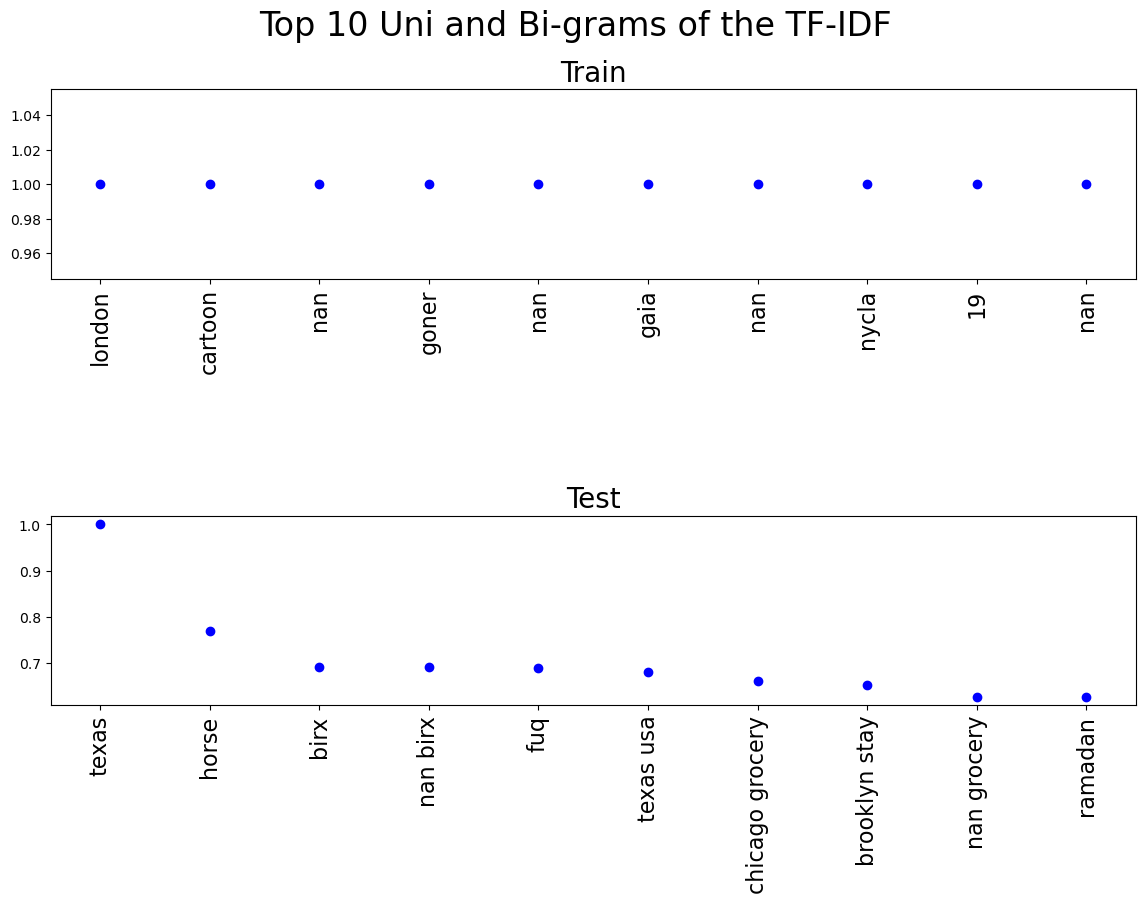

In [23]:
x=range(0, 10)

fig, ax = plt.subplots(2, 1, figsize = (14, 8))
fig.suptitle('Top 10 Uni and Bi-grams of the TF-IDF', fontsize= 24)

# Plot x and tf_idf using blue circle markers
ax[0].plot(x, train_top.tf_idf, 'bo')
ax[0].set_title('Train', fontsize= 20)
# Set number of ticks for x-axis
ax[0].set_xticks(x)
# Set ticks labels for x-axis
x_ticks_labels = train_top.feature
ax[0].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

# Plot x and tf_idf using blue circle markers
ax[1].plot(x, test_top.tf_idf, 'bo')
ax[1].set_title('Test', fontsize= 20)
# Set number of ticks for x-axis
ax[1].set_xticks(x)
# Set ticks labels for x-axis
x_ticks_labels = test_top.feature
ax[1].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

# Adjust horizontal space
fig.subplots_adjust(hspace=1.25)
plt.show()

In [24]:
%%time
# Visualize the top 10 term frequency of the tokens associated with positive tweets using scattertext
corpus = st.CorpusFromPandas(train, category_col='Sentiment', text_col='tweet_texts', nlp=nlp).build()

# Create term freq for sentiment 
term_freq = corpus.get_term_freq_df()
# Create positive tweet for positive sentiment
term_freq['Positive Tweet'] = corpus.get_scaled_f_scores('Positive')
# Rank them by descending order
term_freq_freq = term_freq.sort_values(by= 'Positive freq', ascending=False)
term_freq_score = term_freq.sort_values(by='Positive Tweet', ascending=False)

CPU times: total: 5min 7s
Wall time: 6min 52s


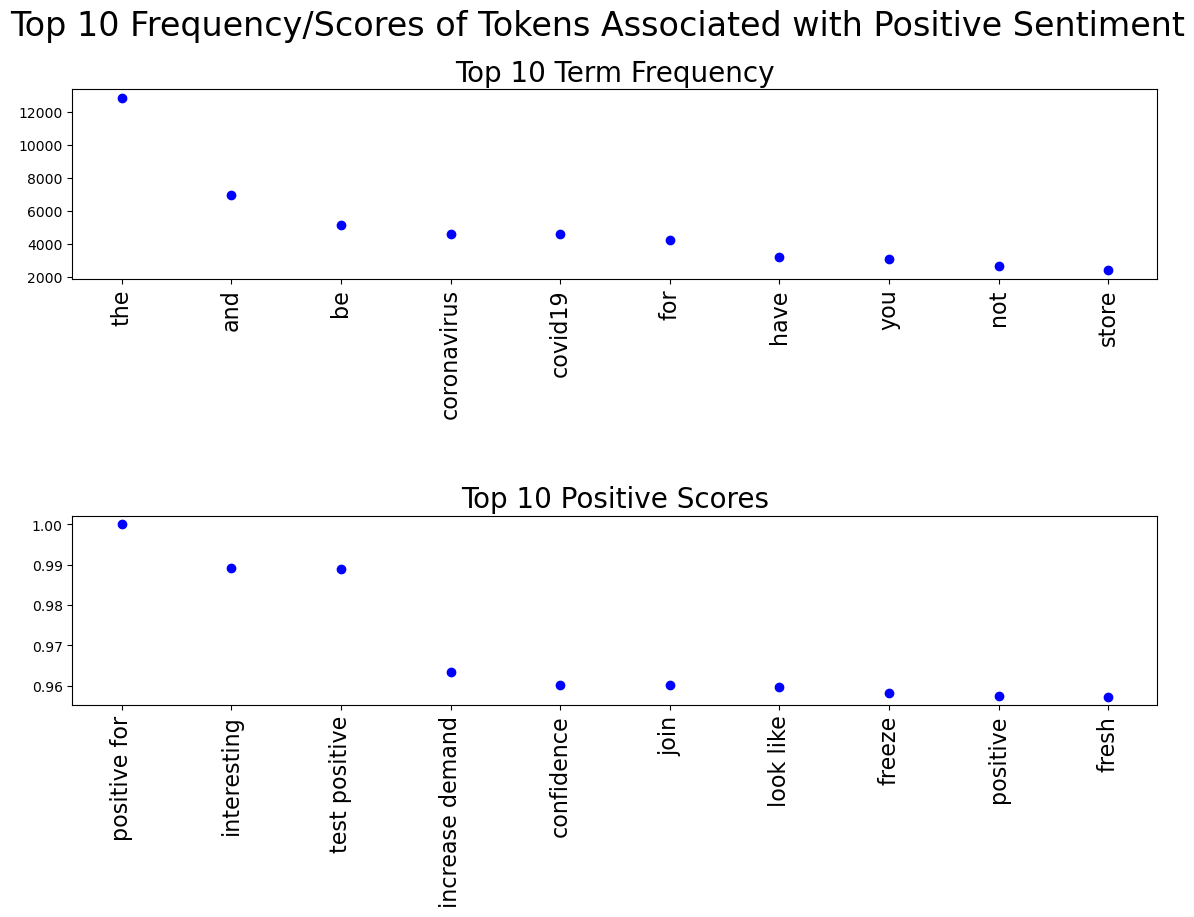

In [25]:
# Visualize the top 10 positive scores of the tokens associated with positive tweets using scattertext
# Plotting both top 10 frequency and scores
term_freq_head= term_freq_freq.head(10)
term_score_head = term_freq_score.head(10)
x = range(0, 10)

fig, ax = plt.subplots(2, 1, figsize = (14, 8))
fig.suptitle('Top 10 Frequency/Scores of Tokens Associated with Positive Sentiment', fontsize= 24)

# Plot freq
ax[0].plot(x, term_freq_head["Positive freq"], 'bo')
ax[0].set_title('Top 10 Term Frequency', fontsize= 20)
# Set number of ticks for x-axis
ax[0].set_xticks(x)
# Set ticks labels for x-axis to be the tokens
x_ticks_labels = term_freq_head.index
ax[0].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

# Plot score
ax[1].plot(x, term_score_head["Positive Tweet"], 'bo')
ax[1].set_title('Top 10 Positive Scores', fontsize= 20)
ax[1].set_xticks(x)
x_ticks_labels = term_score_head.index
ax[1].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

fig.subplots_adjust(hspace=1.25)
plt.show()

In [26]:
# Convert the column of the Tweet_texts to a matrix of token counts using CountVectorizer and unigrams and bigrams
# Create a Vectorizer Object using 1-grams and 2-grams
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')

# Convert tweet_texts to matrix of token counts
matrix = vectorizer.fit_transform(train['tweet_texts'])
  
# Summarizing the numerical features from texts
print(f'The size of the feature matrix = {matrix.get_shape()}')
print(f'The first row of the feature matrix = {matrix[0, ]}.')
print(f'There are {matrix[0, ].count_nonzero()}/{matrix.get_shape()[1]} non-zeros')

The size of the feature matrix = (41156, 439690)
The first row of the feature matrix =   (0, 227492)	1.
There are 1/439690 non-zeros


In [27]:
# Perform the tf-idf analysis on the column of the Tweet_texts using Tfidfvectorizer
# Create a TfidfVectorizer Object using default parameters with stop_words
tfidf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, sublinear_tf=False, stop_words='english')

# Fit to the corpus, then convert a collection of raw documents to a matrix of TF-IDF features.
tfidf_matrix = tfidf_vectorizer.fit_transform(train['tweet_texts'])

print(f'The size of the tfidf matrix = {tfidf_matrix.get_shape()}')
print(f'The sparse tfidf matrix is as follows:')
print(tfidf_matrix)

The size of the tfidf matrix = (41156, 52150)
The sparse tfidf matrix is as follows:
  (0, 28056)	1.0
  (1, 33842)	0.1282911969416686
  (1, 29674)	0.21762578983535483
  (1, 38610)	0.18392348669080724
  (1, 44975)	0.1116162014678342
  (1, 3230)	0.22243032856694428
  (1, 36317)	0.28584724105529113
  (1, 3048)	0.18308788484736271
  (1, 41913)	0.10168764185564777
  (1, 33592)	0.09719398103918514
  (1, 41445)	0.15707782615081328
  (1, 9781)	0.2135448890537338
  (1, 16642)	0.204954775096374
  (1, 40819)	0.16510113238983373
  (1, 27706)	0.1505798842554234
  (1, 11393)	0.1564535476867728
  (1, 12818)	0.1560705382736634
  (1, 32918)	0.3086074835661549
  (1, 35559)	0.35055180397549257
  (1, 17390)	0.2135448890537338
  (1, 17820)	0.13332428692260104
  (1, 31935)	0.4021991688111941
  (1, 45468)	0.1554687426261607
  (1, 3349)	0.16406058680220964
  (2, 34034)	0.20412692524531462
  :	:
  (41154, 40413)	0.25851183520758014
  (41154, 21672)	0.25981606041905647
  (41154, 31579)	0.17255578925092382
  (41

In [28]:
# Find the cosine similarity in Tweet_texts between the 200th and 20,000th tweets
# Create temp objects to store only 200th and 20000th tweets
temp_df = train.iloc[[199, 19999],:].reset_index(drop=True)
temp_tfidf = tfidf_vectorizer.fit_transform(temp_df.tweet_texts)

cos_sim = cosine_similarity(temp_tfidf, dense_output=True)
print(f"The cosine similarity between '{temp_df.tweet_texts[0]}' and '{temp_df.tweet_texts[1]}' = {cos_sim[0,1]}")

The cosine similarity between 'Cambridge our retail store will close through the end March be do this keep our staff and customer safe during the covid19 crisis will continue fulfill and ship out order place online pickup will not available until return regular hour ' and 'Navi Mumbai India indialockdown scenario 
 after speech 
 everyone search for food get panic 

  couple Babu long distance relationship tikegi 

 Covid19india Sarcasm coronavirus stayathomesavelive ' = 0.0


In [29]:
%%time
# Find the corpus vector equal to the average of all the document vectors, where each document corresponds to a tweet or a row in this dataset
tweets_list = [tweet for tweet in train.tweet_texts]

# Compute the average of all document vectors in dataset
avg_vec= np.array([nlp(str(tweet)).vector for tweet in tweets_list]).mean(axis=0)
print(avg_vec)

[-0.5706834   0.4338687  -1.7423074   0.82568496  2.2859871   0.24167739
  0.53742784  2.838923   -1.2156216   0.38721514  3.9650457   1.2401731
 -3.7507362   1.1759759   0.43031976  0.72622526  1.8120308  -0.8659222
 -1.4720271  -1.3319875   0.45363843 -0.1270541  -0.82497233 -0.6687156
 -0.62856597 -0.72040933 -2.210626   -0.63272023 -0.5770845   0.75767064
  2.1064596  -0.07601105 -1.107888   -1.4737389  -0.35914895 -1.0847328
 -0.02533256  1.4152733   1.2839364   0.96642655 -0.18627898  0.7890836
  0.508637    0.4990795  -0.9090396   1.1542045   1.3428756  -2.4840522
 -0.00715508  0.8885751  -0.14841309  1.5682257  -0.01897542 -3.762753
 -1.0926847   0.77065164 -0.6420756   1.0314058   0.63659966  0.5895006
  1.140549   -0.24937634 -0.8939152  -1.2318407   2.0430741   1.111636
 -2.5790493  -1.4804446   0.50240576  2.1899762  -0.38043147  0.0879057
 -1.037784   -0.03349785 -0.17705907  1.6881629  -1.0983987   0.19032532
 -1.2511269  -0.27399033 -3.024567    0.6593886   1.2209911   0

In [30]:
train['Sentiment'].value_counts(normalize=True)

Sentiment
Positive              0.277529
Negative              0.240961
Neutral               0.187385
Extremely Positive    0.160949
Extremely Negative    0.133176
Name: proportion, dtype: float64

In [31]:
# Build the first model based on the training dataset using the random forests and pipeline
# (Extremely Negative:0, Extremely Positive:1, Negative:2, Neutral:3, Positive:4), to track original labels
le = LabelEncoder()

train['Sentiment'] = le.fit_transform(train['Sentiment'])
test['Sentiment'] = le.fit_transform(test['Sentiment'])
# Note target is slightly imbalanced
train['Sentiment'].value_counts(normalize=True)

Sentiment
4    0.277529
2    0.240961
3    0.187385
1    0.160949
0    0.133176
Name: proportion, dtype: float64

In [32]:
X_train = train['tweet_texts']
y_train = train['Sentiment']
X_test = test['tweet_texts']
y_test = test['Sentiment']
# Chheck missing values
print(X_train.isnull().sum() * 100 / len(X_train))
print(y_train.isnull().sum() * 100 / len(y_train))
print(X_test.isnull().sum() * 100 / len(X_test))
print(y_test.isnull().sum() * 100 / len(y_test))

0.0
0.0
0.0
0.0


In [33]:
# To save runtime on following grid searches, I will create sample data for train here using 25%
X_train_sample, X_nouse, y_train_sample, y_nouse = train_test_split(X_train, y_train, test_size = 0.75, random_state = 123, stratify=y_train)

print(f'X_train_sample dimension: {X_train_sample.shape}; y_train_sample dimension: {y_train_sample.shape}')

X_train_sample dimension: (10289,); y_train_sample dimension: (10289,)


In [34]:
%%time
# No cleaning text part of pipeline because I did that using regex at start of project, tfidf_vectorizer created previously with default settings
rf = RandomForestClassifier(random_state=123)
pipeline = Pipeline([("vectorizer", tfidf_vectorizer), ("classifier", rf)])
pipeline.fit(X_train_sample, y_train_sample)

CPU times: total: 25.2 s
Wall time: 30.8 s


Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('classifier', RandomForestClassifier(random_state=123))])

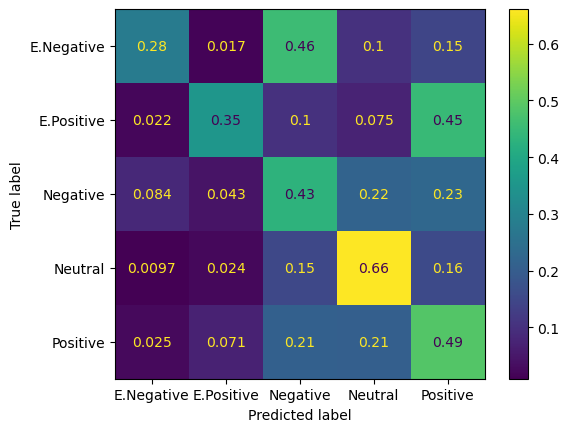

In [35]:
# Check the first model on the test dataset

y_pred = pipeline.predict(X_test)
target_names= ['E.Negative', 'E.Positive', 'Negative', 'Neutral', 'Positive']
# Print confusion matrix with percent
cm_matrix = confusion_matrix(y_test, y_pred, normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix= cm_matrix, display_labels=target_names).plot()

In [36]:
# Print out the report
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

  E.Negative       0.56      0.28      0.37       592
  E.Positive       0.61      0.35      0.45       599
    Negative       0.42      0.43      0.42      1041
     Neutral       0.44      0.66      0.53       619
    Positive       0.40      0.49      0.44       947

    accuracy                           0.45      3798
   macro avg       0.48      0.44      0.44      3798
weighted avg       0.47      0.45      0.44      3798



The RF model scores seem okay. Given I have 5 possible classes, I expect lower scores than a binary classification model. In terms of accuracy, the CM shows the highest accuracy for neutral tweets with overall accuracy of 45%. F1-scores are also similar, with the highest f1 scores belonging to neutral and lowest to extremely negative. Next, I will tune this model using GridSearchCV. 

In [37]:
# 17. Create the second model using pipeline, grid search CV for the hyperparameters for the estimators
parameters = {
    'vectorizer__max_df': (0.75,0.9, 1.0),
    'vectorizer__norm': ('l1', 'l2'),
    'classifier__n_estimators': (100, 250), # 100 default
    'classifier__criterion': ('gini', 'entropy'), # gini default
    'classifier__min_impurity_decrease': (0.0, 0.01), # default is 0
    'classifier__class_weight': ('balanced', None) # default is None
}
grid_search_rf = GridSearchCV(pipeline, parameters, n_jobs=None, cv=3, verbose=1)
print("The pipeline contains:", [name for name, _ in pipeline.steps])
print("parameters are as follows:")
pprint(parameters)

The pipeline contains: ['vectorizer', 'classifier']
parameters are as follows:
{'classifier__class_weight': ('balanced', None),
 'classifier__criterion': ('gini', 'entropy'),
 'classifier__min_impurity_decrease': (0.0, 0.01),
 'classifier__n_estimators': (100, 250),
 'vectorizer__max_df': (0.75, 0.9, 1.0),
 'vectorizer__norm': ('l1', 'l2')}


In [38]:
%%time
# Tune the second model and perform model diagnostics on the test dataset.
# Fit on train sample
grid_search_rf.fit(X_train_sample, y_train_sample)

print(f"Best score= {grid_search_rf.best_score_:0.3f}")
print("Best parameters set:")
best_parameters = grid_search_rf.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best score= 0.465
Best parameters set:
	classifier__class_weight: 'balanced'
	classifier__criterion: 'gini'
	classifier__min_impurity_decrease: 0.0
	classifier__n_estimators: 250
	vectorizer__max_df: 0.75
	vectorizer__norm: 'l1'
CPU times: total: 44min 25s
Wall time: 1h 22min 33s


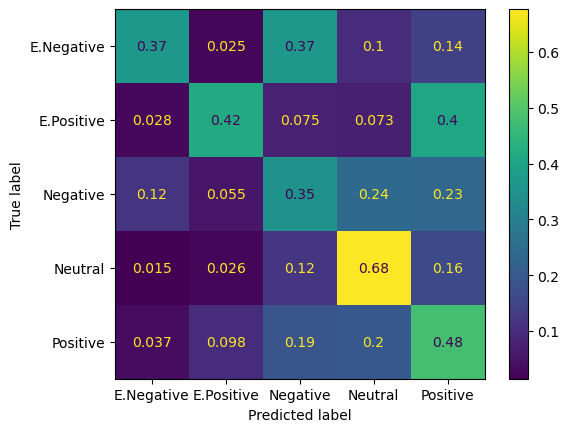

In [39]:
# Predict the test data
y_pred1 = grid_search_rf.predict(X_test)

# Print confusion matrix with percent
cm_matrix = confusion_matrix(y_test, y_pred1, normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix= cm_matrix, display_labels=target_names).plot()

In [40]:
# Print out the report
print(classification_report(y_test, y_pred1, target_names = target_names))

              precision    recall  f1-score   support

  E.Negative       0.55      0.37      0.44       592
  E.Positive       0.58      0.42      0.49       599
    Negative       0.42      0.35      0.38      1041
     Neutral       0.44      0.68      0.53       619
    Positive       0.40      0.48      0.44       947

    accuracy                           0.45      3798
   macro avg       0.48      0.46      0.46      3798
weighted avg       0.46      0.45      0.45      3798



The tuned RF model is only slightly better than the untuned model using balanced class_weight and 250 n_estimators. The best vectorizer hyperparameters were not the default, with max_df=0.75 and norm='l1'. The biggest change in score is the f1 score for E.Negative which increased from 0.37 to 0.44. Overall accuracy remains the same. 

In [41]:
# Build the third model using pipeline, grid search CV, hyperparameter for the following classifiers: Logistic regression, SVM, RF
# Define the estimator class to handle different classifiers
class ClfSwitcher(BaseEstimator):
    # Initialize the estimator using SVC()
    def __init__(
        self,
        estimator = RandomForestClassifier(),
    ):
        self.estimator = estimator
    # Fit the model using the given estimator
    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self
    # Predict the label using the given estimator
    def predict(self, X, y=None):
        return self.estimator.predict(X)
    # Predict the probability using the given estimator
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    # Compute the score using the given estimator
    def score(self, X, y):
        return self.estimator.score(X, y)

In [48]:
pipeline2 = Pipeline([("vectorizer", tfidf_vectorizer), ("classifier", ClfSwitcher())])
parameters2 = [
    {
        'classifier__estimator': [RandomForestClassifier(random_state=123)] # As I already tuned RF before, I will focus parameters on other 2 models to save time
    },
    {
        'vectorizer__max_df': (0.75, 1),
        'vectorizer__norm': ('l1', 'l2'),
        'classifier__estimator': [LogisticRegression(random_state=123)],
        'classifier__estimator__C': (0.1, 1, 10), # Regularization parameter, default = 1.0
        'classifier__estimator__solver': ('lbfgs','newton-cg','sag'), # these 3 solvers either use l2 or None penalty and work for multinomial loss
        'classifier__estimator__penalty': ('l2', None),
        'classifier__estimator__class_weight': ['balanced'] # default = None, not including None in grid to save runtime
    },
    {
        'vectorizer__max_df': (0.75, 1),
        'vectorizer__norm': ('l1', 'l2'),
        'classifier__estimator': [SVC(random_state=123)],
        'classifier__estimator__kernel': ('rbf', 'poly', 'sigmoid'), # default is rbf
        'classifier__estimator__C': (0.1, 1, 10), # 1 default
        'classifier__estimator__class_weight': ['balanced'], # None default
    }
]

print("The pipeline contains:", [name for name, _ in pipeline2.steps])
print("parameters are as follows:")
pprint(parameters2)

The pipeline contains: ['vectorizer', 'classifier']
parameters are as follows:
[{'classifier__estimator': [RandomForestClassifier(random_state=123)]},
 {'classifier__estimator': [LogisticRegression(random_state=123)],
  'classifier__estimator__C': (0.1, 1, 10),
  'classifier__estimator__class_weight': ['balanced'],
  'classifier__estimator__penalty': ('l2', None),
  'classifier__estimator__solver': ('lbfgs', 'newton-cg', 'sag'),
  'vectorizer__max_df': (0.75, 1),
  'vectorizer__norm': ('l1', 'l2')},
 {'classifier__estimator': [SVC(random_state=123)],
  'classifier__estimator__C': (0.1, 1, 10),
  'classifier__estimator__class_weight': ['balanced'],
  'classifier__estimator__kernel': ('rbf', 'poly', 'sigmoid'),
  'vectorizer__max_df': (0.75, 1),
  'vectorizer__norm': ('l1', 'l2')}]


In [49]:
%%time
warnings.filterwarnings('ignore')
# Tune the third model and perform model diagnostics on the test dataset. 
grid_search = GridSearchCV(pipeline2, parameters2, cv=3, verbose=1)
grid_search.fit(X_train_sample, y_train_sample)
warnings.filterwarnings('default')

Fitting 3 folds for each of 109 candidates, totalling 327 fits
CPU times: total: 17min 50s
Wall time: 24min 50s


In [50]:
print(f"Best score= {grid_search.best_score_:0.3f}")
best_parameters = grid_search.best_estimator_.get_params()

# loop over the parameters and get all potential algorithms in the pipeline
all_classifiers =[]
for parameter in parameters2:
    all_classifiers.append(parameter['classifier__estimator'])
all_classifiers = [str(alg) for clf in all_classifiers for alg in clf]
print("All potential classifiers:")
pprint(all_classifiers)

# Print the best_parameters
print(f'\n {best_parameters}')

Best score= 0.484
All potential classifiers:
['RandomForestClassifier(random_state=123)',
 'LogisticRegression(random_state=123)',
 'SVC(random_state=123)']

 {'memory': None, 'steps': [('vectorizer', TfidfVectorizer(max_df=0.75, stop_words='english')), ('classifier', ClfSwitcher(estimator=SVC(C=1, class_weight='balanced', kernel='sigmoid',
                          random_state=123)))], 'verbose': False, 'vectorizer': TfidfVectorizer(max_df=0.75, stop_words='english'), 'classifier': ClfSwitcher(estimator=SVC(C=1, class_weight='balanced', kernel='sigmoid',
                          random_state=123)), 'vectorizer__analyzer': 'word', 'vectorizer__binary': False, 'vectorizer__decode_error': 'strict', 'vectorizer__dtype': <class 'numpy.float64'>, 'vectorizer__encoding': 'utf-8', 'vectorizer__input': 'content', 'vectorizer__lowercase': True, 'vectorizer__max_df': 0.75, 'vectorizer__max_features': None, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__norm': 'l2', 'v

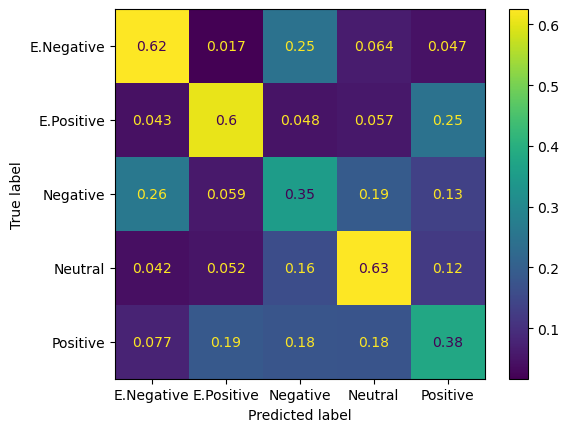

In [51]:
# Predict the test data
y_pred2 = grid_search.predict(X_test)

# Print confusion matrix with percent
cm_matrix = confusion_matrix(y_test, y_pred2, normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix= cm_matrix, display_labels=target_names).plot()

In [52]:
# Print out the report
print(classification_report(y_test, y_pred2, target_names = target_names))

              precision    recall  f1-score   support

  E.Negative       0.48      0.62      0.54       592
  E.Positive       0.56      0.60      0.58       599
    Negative       0.45      0.35      0.40      1041
     Neutral       0.47      0.63      0.54       619
    Positive       0.48      0.38      0.43       947

    accuracy                           0.49      3798
   macro avg       0.49      0.52      0.50      3798
weighted avg       0.48      0.49      0.48      3798



My best model is the vectorizer using max_df=0.75 and norm=l2 with SVC using C=1, class_weight = balanced, and sigmoid kernel. I verified the best hyperparameters by looking at best_parameters. Notice an increase in accuracy from 0.45 to 0.49, as well as increases to f1-scores across all groups with E.Negative increasing from 0.44 to 0.54 and E.Positive increasing from 0.49 to 0.58. 

In [53]:
%%time
# Generate the first topic model by setting five topics using LDA method and CountVectorizer
# Ignore terms that have document frequency higher than 90%
count_vectorizer = CountVectorizer(max_df=0.9, stop_words='english')
doc_word_matrix = count_vectorizer.fit_transform(train['tweet_texts'])
# 5 topics
lda = LatentDirichletAllocation(n_components= 5,random_state= 123)
lda.fit(doc_word_matrix)

CPU times: total: 1min 8s
Wall time: 1min 54s


LatentDirichletAllocation(n_components=5, random_state=123)

In [54]:
# Plot the top 15 words for each topic for the model above
def plot_top_words(model, feature_names, title, n_top_words=15):
    # We specify 5 topics, then we setup the number of subplot =5*1
    fig, axes = plt.subplots(5, 1, figsize=(30, 30), sharex=True)
    # Flatten the axes to 1 D vector, then we can loop it easily instead of using a nested loop for rows and columns
    axes = axes.flatten()
    
    # Loop over all the topics
    for topic_idx, topic in enumerate(model.components_):
        # Rank the values and take out the corresponding indices
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        # Take out the top features using the indices
        top_features = [feature_names[i] for i in top_features_ind]
        # Get the weights
        weights = topic[top_features_ind]
        # Take out the axes from the flattened 1D vector
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        # Remove the top, right and left axis in matplotlib
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

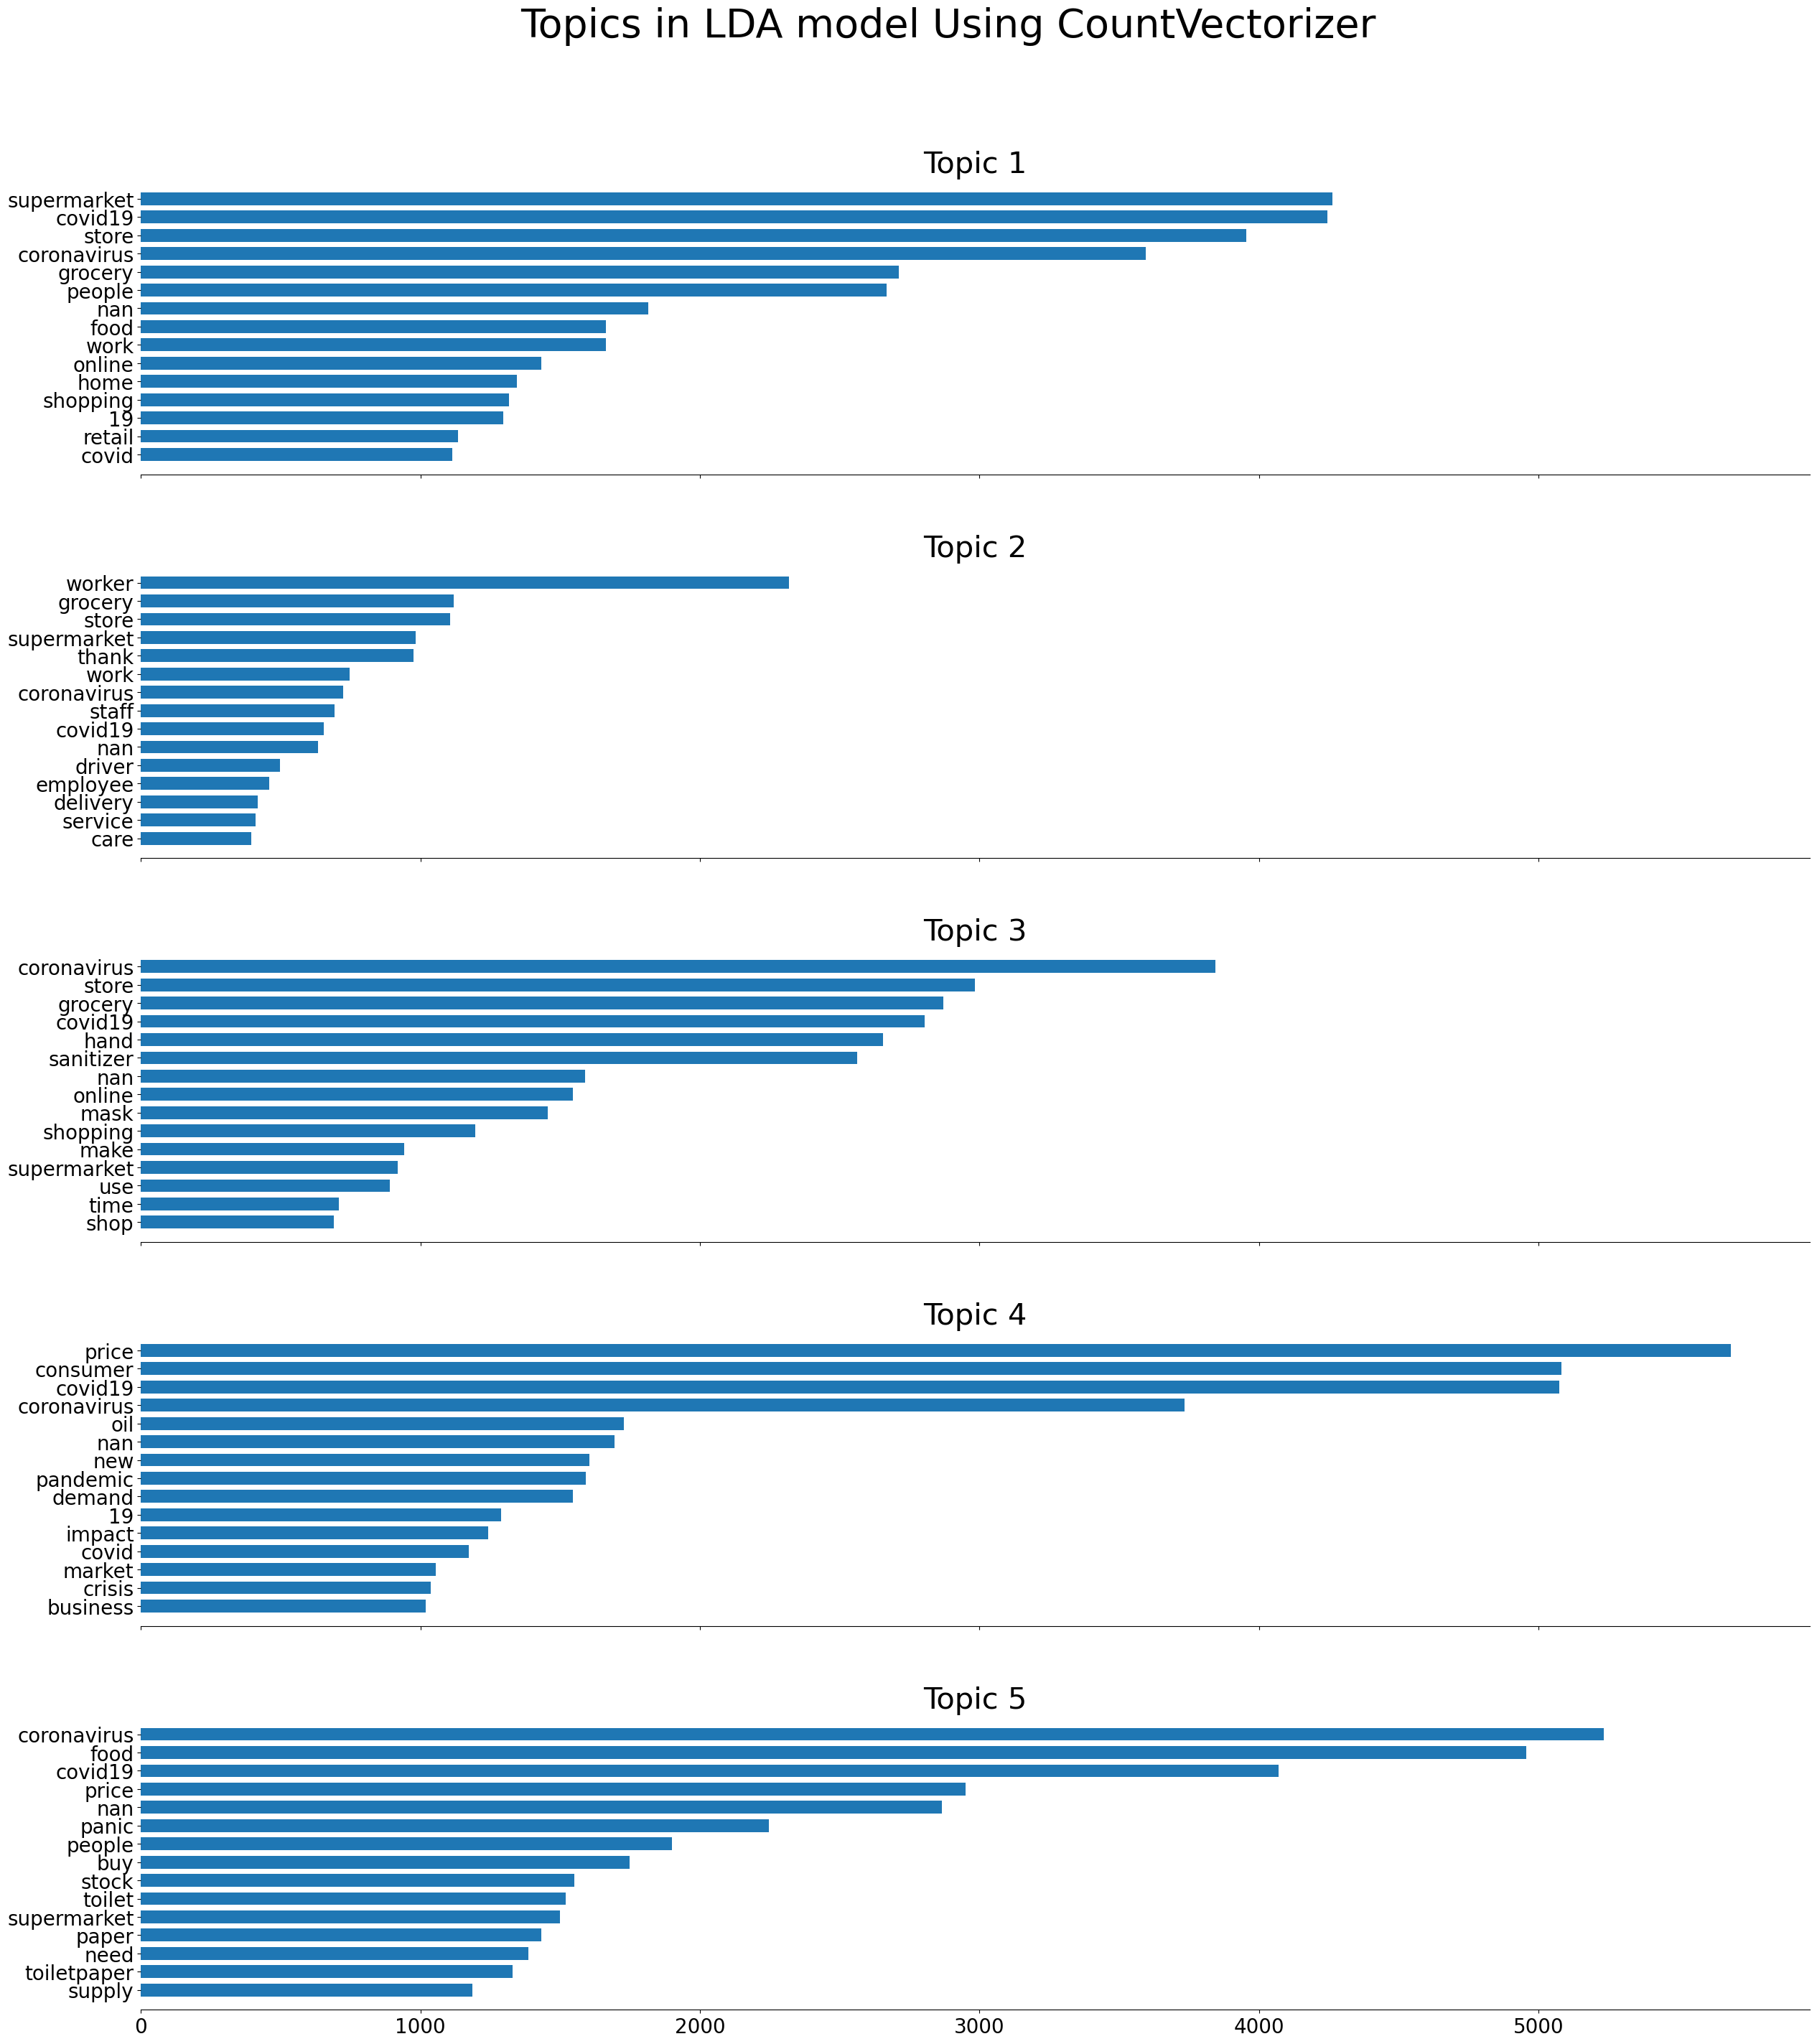

In [55]:
count_feature_names = count_vectorizer.get_feature_names_out()
plot_top_words(lda, count_feature_names, 'Topics in LDA model Using CountVectorizer')

In [56]:
# Generate the second topic model by setting five topics using LDA method and TfidfVectorizer
tfidf_final = TfidfVectorizer(stop_words = 'english', lowercase = True, # Convert the tokens to lower cases
                                # Specify the token using regular expression to consider tokens of 2 for more alphanumeric characters
                                token_pattern = r'\b[a-zA-Z0-9]{2,}\b', max_df = 0.9)
doc_word_matrix_tf = tfidf_final.fit_transform(train['tweet_texts'])

lda_tf = LatentDirichletAllocation(n_components=5, random_state= 123)
lda_tf.fit(doc_word_matrix_tf)

LatentDirichletAllocation(n_components=5, random_state=123)

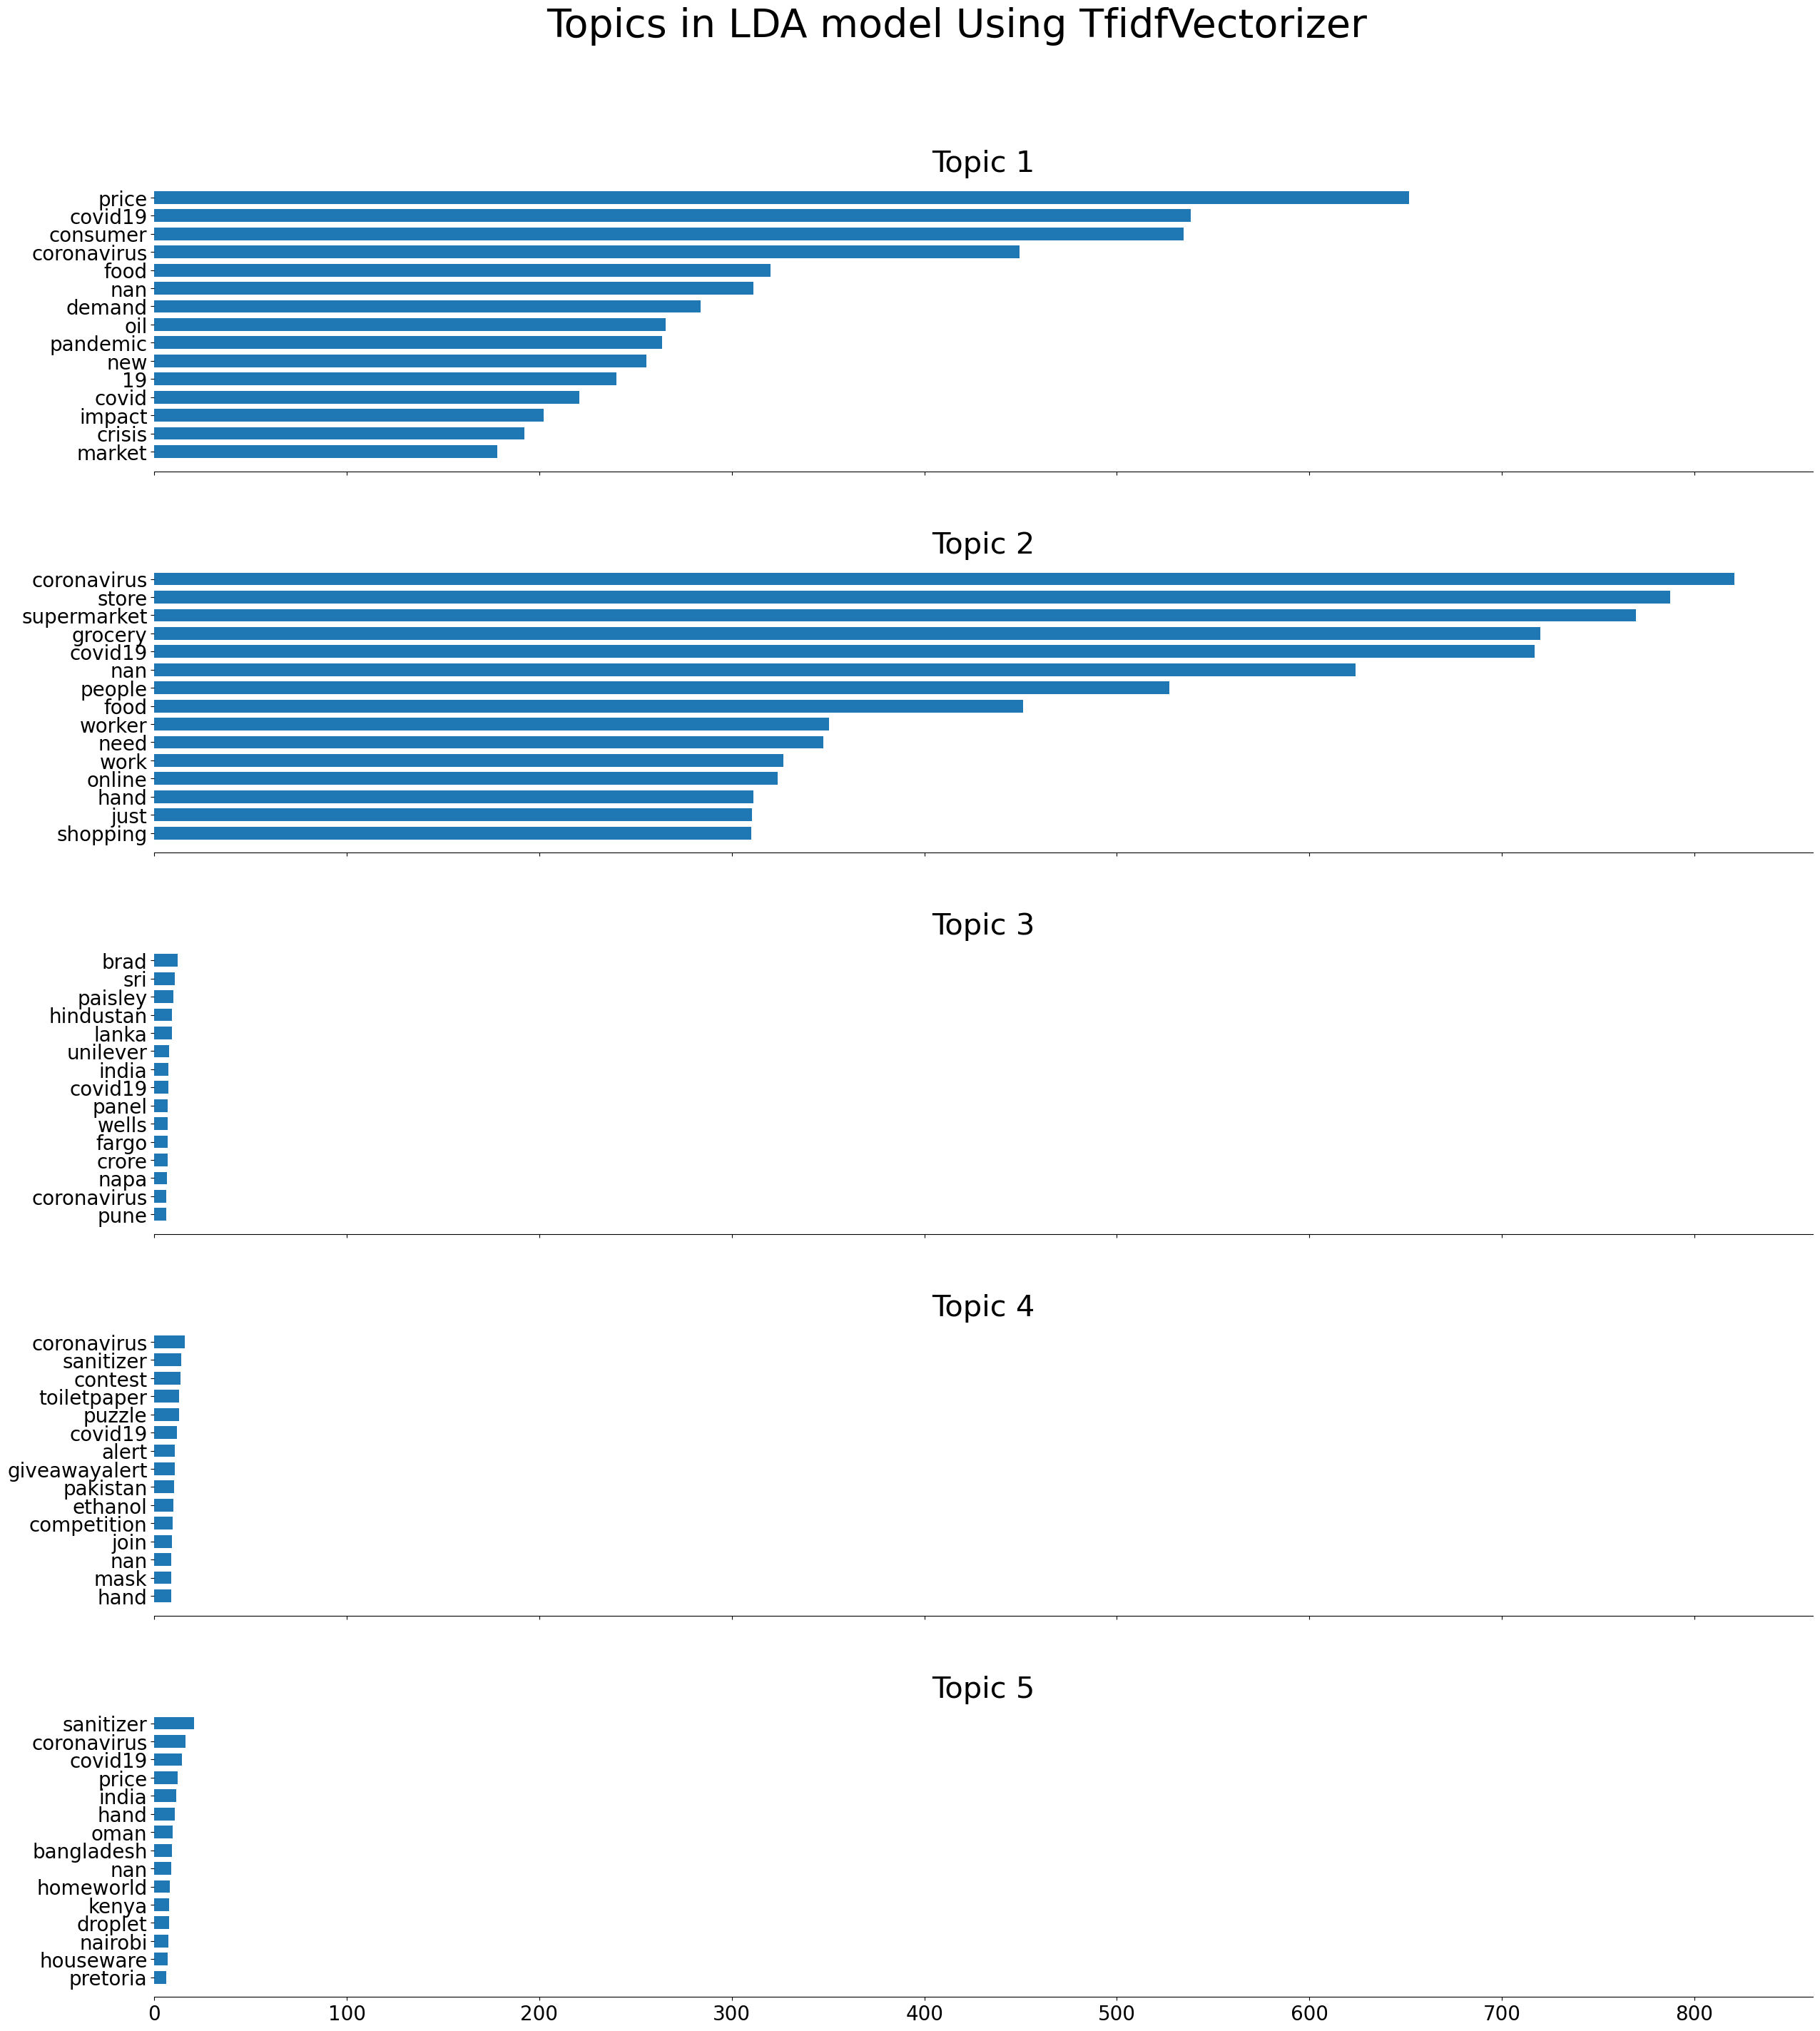

In [57]:
# Plot the top 15 words for each topic for the second model above
tf_feature_names = tfidf_final.get_feature_names_out()
plot_top_words(lda_tf, tf_feature_names, 'Topics in LDA model Using TfidfVectorizer')

In [ ]:
# Note: output of this cell deleted due to interfering with html rendering

# Visualize the second topic model using the dimension reduction method
# To visualize the second topic model, click the circle with 2
# Enable automatic D3 display

pyLDAvis.enable_notebook()

# Visualize topic model with default mds='pcoa'
pyLDAvis.lda_model.prepare(lda_model = lda_tf, dtm = doc_word_matrix_tf, vectorizer = tfidf_final)